<a href="https://colab.research.google.com/github/Omri-Naishtein/Neuro-PID/blob/main/PID_inside_loop_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
#this code is using only math - no high end libs like TF or Keras, so it could be used in micropython and MCU such as jetson nano or raspberry pi

In [20]:
import math
import time
import numpy as np

DT = 0.005
T_TOTAL = 10.0
STEPS = int(T_TOTAL / DT)

class SimpleDCMotor:
	def __init__(self, J=0.01, b=0.1, Kt=0.1, max_u=12.0):
		self.J = J
		self.b = b
		self.Kt = Kt
		self.max_u = max_u
		self.theta = 0.0
		self.omega = 0.0
	def step(self, u, dt):
		u = float(np.clip(u, -self.max_u, self.max_u))
		torque = self.Kt * u
		omega_dot = (torque - self.b * self.omega) / self.J
		self.omega += omega_dot * dt
		self.theta += self.omega * dt
		return self.theta, self.omega

class PIDController:
	def __init__(self, Kp=2.0, Ki=0.0, Kd=0.0, integral_limit=100.0):
		self.Kp = float(Kp); self.Ki = float(Ki); self.Kd = float(Kd)
		self.integral = 0.0; self.last_e = 0.0
		self.integral_limit = integral_limit
	def reset(self):
		self.integral = 0.0; self.last_e = 0.0
	def compute(self, e, dt):
		self.integral += e * dt
		if self.integral > self.integral_limit: self.integral = self.integral_limit
		if self.integral < -self.integral_limit: self.integral = -self.integral_limit
		deriv = (e - self.last_e) / (dt if dt>0 else 1e-8)
		self.last_e = e
		u = self.Kp * e + self.Ki * self.integral + self.Kd * deriv
		return u

class TinyMLP:
	def __init__(self, input_dim=10, hidden=48, out_dim=3, seed=0):
		rng = np.random.RandomState(seed)
		self.w1 = rng.randn(hidden, input_dim) * 0.1
		self.b1 = np.zeros((hidden,))
		self.w2 = rng.randn(out_dim, hidden) * 0.1
		self.b2 = np.zeros((out_dim,))
		self.dw1 = np.zeros_like(self.w1); self.db1 = np.zeros_like(self.b1)
		self.dw2 = np.zeros_like(self.w2); self.db2 = np.zeros_like(self.b2)
	def forward(self, x):
		z1 = self.w1.dot(x) + self.b1
		a1 = np.maximum(z1, 0.0)
		z2 = self.w2.dot(a1) + self.b2
		self._x = x; self._z1 = z1; self._a1 = a1; self._z2 = z2
		return z2.copy()
	def backward_from_dout(self, dL_dout):
		self.dw2 = np.outer(dL_dout, self._a1)
		self.db2 = dL_dout.copy()
		da1 = self.w2.T.dot(dL_dout)
		dz1 = da1 * (self._z1 > 0).astype(float)
		self.dw1 = np.outer(dz1, self._x)
		self.db1 = dz1.copy()
	def step_sgd(self, lr=1e-4, clip=1.0):
		for g in [self.dw1, self.dw2, self.db1, self.db2]:
			norm = np.linalg.norm(g)
			if norm > clip and norm>0:
				g *= (clip / norm)
		self.w1 -= lr * self.dw1
		self.b1 -= lr * self.db1
		self.w2 -= lr * self.dw2
		self.b2 -= lr * self.db2

def build_feature_vector(e_hist, integral, u_hist, sp, noise_est=0.0, env_flag=0.0):
	feat = np.array([e_hist[0], e_hist[1], e_hist[2], integral, (e_hist[0]-e_hist[1]), u_hist[0], u_hist[1], sp, noise_est, env_flag], dtype=np.float32)
	return feat

def simulate_step_with_gains(theta, omega, gains, e_hist, u_hist, sp, dt, motor_template, pid_integral, pid_last_e):
	temp_motor = SimpleDCMotor(J=motor_template.J, b=motor_template.b, Kt=motor_template.Kt, max_u=motor_template.max_u)
	temp_motor.theta = theta; temp_motor.omega = omega
	temp_pid = PIDController(Kp=gains[0], Ki=gains[1], Kd=gains[2], integral_limit=100.0)
	temp_pid.integral = pid_integral; temp_pid.last_e = pid_last_e
	e = sp - temp_motor.theta
	u = temp_pid.compute(e, dt)
	temp_motor.step(u, dt)
	e_next = sp - temp_motor.theta
	return e_next, temp_motor.theta, temp_motor.omega

np.random.seed(0)
motor = SimpleDCMotor(J=0.01, b=0.15, Kt=0.2, max_u=12.0)
pid = PIDController(Kp=2.0, Ki=0.0, Kd=0.0, integral_limit=100.0)
mlp = TinyMLP(input_dim=10, hidden=48, out_dim=3, seed=1)

LR = 5e-4
EPSILON = 1e-3
CLIP = 0.1

times = []
errors = []
kp_log = []
ki_log = []
kd_log = []
u_log = []
theta_log = []
omega_log = []

motor.theta = 0.0; motor.omega = 0.0; pid.reset()
e_hist = [0.0,0.0,0.0]
u_hist = [0.0,0.0]
sp = 1.0
noise = 0.0

for step in range(STEPS):
	t = step * DT
	times.append(t)
	theta = motor.theta; omega = motor.omega
	e = sp - theta
	feat = build_feature_vector(e_hist, pid.integral, u_hist, sp, noise, 0.0)
	out = mlp.forward(feat)
	new_gains = np.array([pid.Kp + out[0], pid.Ki + out[1], pid.Kd + out[2]], dtype=float)
	new_gains[0] = float(np.clip(new_gains[0], 0.0, 500.0))
	new_gains[1] = float(np.clip(new_gains[1], 0.0, 200.0))
	new_gains[2] = float(np.clip(new_gains[2], 0.0, 100.0))
	pid.Kp, pid.Ki, pid.Kd = new_gains[0], new_gains[1], new_gains[2]
	u = pid.compute(e, DT)
	theta, omega = motor.step(u, DT)
	e_next = sp - theta
	errors.append(e)
	kp_log.append(pid.Kp); ki_log.append(pid.Ki); kd_log.append(pid.Kd)
	u_log.append(u); theta_log.append(theta); omega_log.append(omega)
	L0 = 0.5 * (e_next**2)
	dL_dout = np.zeros(3, dtype=float)
	for j in range(3):
		out_pert = out.copy()
		out_pert[j] += EPSILON
		gains_pert = np.array([pid.Kp + out_pert[0], pid.Ki + out_pert[1], pid.Kd + out_pert[2]])
		gains_pert[0] = float(np.clip(gains_pert[0], 0.0, 500.0))
		gains_pert[1] = float(np.clip(gains_pert[1], 0.0, 200.0))
		gains_pert[2] = float(np.clip(gains_pert[2], 0.0, 100.0))
		L_pert, _, _ = simulate_step_with_gains(theta=theta - motor.omega*DT, omega=omega, gains=gains_pert, e_hist=e_hist, u_hist=u_hist, sp=sp, dt=DT, motor_template=motor, pid_integral=pid.integral, pid_last_e=e_hist[0])
		L_pert_val = 0.5 * (L_pert**2)
		dL_dout[j] = (L_pert_val - L0) / EPSILON
	mlp.backward_from_dout(dL_dout)
	mlp.step_sgd(lr=LR, clip=CLIP)
	e_hist = [e] + e_hist[:2]
	u_hist = [u] + u_hist[:1]
	if abs(e) > 100:
		pid.integral = 0.0; pid.Kp = 2.0; pid.Ki = 0.0; pid.Kd = 0.0

np.savez_compressed('pid_ai_sim_logs.npz', times=np.array(times), errors=np.array(errors),
					kp=np.array(kp_log), ki=np.array(ki_log), kd=np.array(kd_log),
					u=np.array(u_log), theta=np.array(theta_log), omega=np.array(omega_log))
print("Simulation complete. Logs saved to pid_ai_sim_logs.npz")

Simulation complete. Logs saved to pid_ai_sim_logs.npz


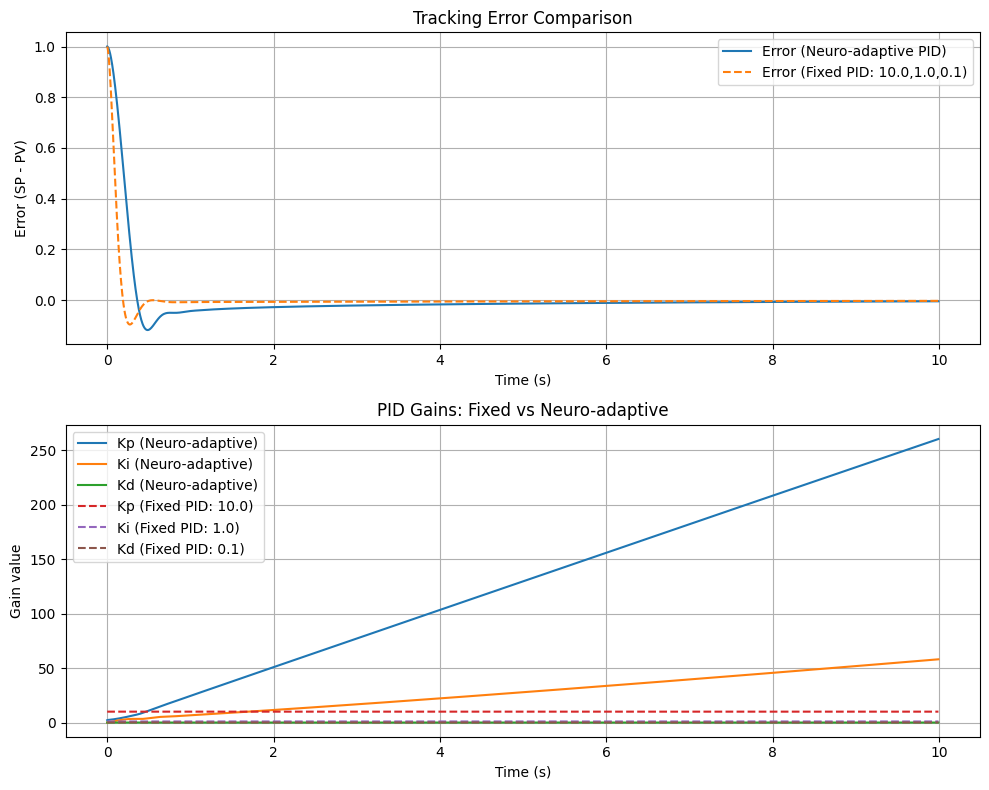

In [21]:
import matplotlib.pyplot as plt

# Fixed PID gains
Kp_fixed = 10.0
Ki_fixed = 1.0
Kd_fixed = 0.1

# Prepare fixed PID gain logs
kp_fixed_log = [Kp_fixed]*len(times)
ki_fixed_log = [Ki_fixed]*len(times)
kd_fixed_log = [Kd_fixed]*len(times)

# Plot both subplots in one figure
fig, axs = plt.subplots(2, 1, figsize=(10,8))

# Subplot 1: Tracking error
# Simulate fixed PID error
motor_fixed = SimpleDCMotor(J=motor.J, b=motor.b, Kt=motor.Kt, max_u=motor.max_u)
pid_fixed = PIDController(Kp=Kp_fixed, Ki=Ki_fixed, Kd=Kd_fixed, integral_limit=100.0)
theta_fixed = 0.0
omega_fixed = 0.0
pid_fixed.reset()
errors_fixed = []

for t in times:
    e_fixed = sp - theta_fixed
    u_fixed = pid_fixed.compute(e_fixed, DT)
    theta_fixed, omega_fixed = motor_fixed.step(u_fixed, DT)
    errors_fixed.append(e_fixed)

axs[0].plot(times, errors, label='Error (Neuro-adaptive PID)')
axs[0].plot(times, errors_fixed, '--', label=f'Error (Fixed PID: {Kp_fixed},{Ki_fixed},{Kd_fixed})')
axs[0].set_title("Tracking Error Comparison")
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("Error (SP - PV)")
axs[0].legend()
axs[0].grid(True)

# Subplot 2: PID gains comparison
axs[1].plot(times, kp_log, label='Kp (Neuro-adaptive)')
axs[1].plot(times, ki_log, label='Ki (Neuro-adaptive)')
axs[1].plot(times, kd_log, label='Kd (Neuro-adaptive)')
axs[1].plot(times, kp_fixed_log, '--', label=f'Kp (Fixed PID: {Kp_fixed})')
axs[1].plot(times, ki_fixed_log, '--', label=f'Ki (Fixed PID: {Ki_fixed})')
axs[1].plot(times, kd_fixed_log, '--', label=f'Kd (Fixed PID: {Kd_fixed})')
axs[1].set_title("PID Gains: Fixed vs Neuro-adaptive")
axs[1].set_xlabel("Time (s)")
axs[1].set_ylabel("Gain value")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()